In [0]:
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default() 
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

In [0]:
!mkdir -p drive
!google-drive-ocamlfuse drive

In [0]:
import os
os.chdir('drive')
!ls

In [0]:
!pip install nibabel

In [0]:
from functools import partial
import numpy as np
from keras import backend as K
from keras.engine import Input, Model
from keras.layers import Conv3D, MaxPooling3D, UpSampling3D, Activation, BatchNormalization, PReLU, Deconvolution3D
from keras.optimizers import Adam
from keras.losses import categorical_crossentropy

K.set_image_dim_ordering('tf')
K.set_image_data_format('channels_first')

try:
    from keras.engine import merge
except ImportError:
    from keras.layers.merge import concatenate

In [0]:
def diceCoef(yTrue, yPred, smooth=1.):
  yPredF1 = K.flatten(yPred)
  yTrueF1 = K.flatten(yTrue)
  yTrueF1 = K.one_hot(K.argmax(yTrueF1), num_classes=4)
  yPredF1 = K.one_hot(K.argmax(yPredF1), num_classes=4)
  intersection = K.sum(yTrueF1 * yPredF1)
  return (2. * intersection + smooth) / (K.sum(yTrueF1) + K.sum(yPredF1) + smooth)

def diceCoefLoss(yTrue, yPred):
	return -diceCoef(yTrue, yPred)

def weightedDiceCoef(yTrue, yPred, axis=(-3, -2, -1), smooth=0.00001):
	return K.mean(2. * (K.sum(yTrue * yPred, axis=axis) + smooth/2) / (K.sum(yTrue, axis=axis) + K.sum(yPred, axis=axis) + smooth))

def weightedDiceCoefLoss(yTrue, yPred):
	return -weightedDiceCoef(yTrue, yPred)

def labeledDiceCoef(yTrue, yPred, labelIndex):
	return diceCoef(yTrue[:, labelIndex], yPred[:, labelIndex])

def getLabeledDiceCoef(labelIndex):
	f = partial(labeledDiceCoef, labelIndex=labelIndex)
	f.__setattr__('__name__', 'label_{0}_dice_coef'.format(labelIndex))
	return f

def oneHot(y, num_classees):
  y_ = np.zeros([len(y), num_classees])
  y_[np.arange(len(y)), y] = 1
  return y_

def diceCoefNp(y_true, y_pred, num_classes=3):
  y_truef = np.asarray(y_true).astype(int)
  y_truef1 = y_truef.flatten()
  y_truef1 = oneHot(y_truef1, num_classes)
  y_predf = np.asarray(y_pred).astype(int)
  y_predf1 = y_predf.flatten()
  y_predf1 = oneHot(y_predf1, num_classes)
  intersection = np.sum(y_truef1 * y_predf1, axis=0)
  return (2. * intersection) / (np.sum(y_truef1, axis=0) + np.sum(y_predf1, axis=0))


In [0]:
def createConv(ipLayer, numFilters, batchNorm=False, kernel=(3, 3, 3), activation=None, padding='same', strides=(1, 1, 1)):
	layer = Conv3D(numFilters, kernel, padding=padding, strides=strides)(ipLayer)
	if batchNorm:
		layer = BatchNormalization(axis=1)(layer)
	if activation is None:
		return Activation('relu')(layer)
	else:
		return activation()(layer)

def getUpConv(numFilters, poolSize, kernel=(2, 2, 2), strides=(2, 2, 2), deconv=False):
	if deconv:
		return Deconvolution3D(filters=numFilters, kernel_size=kernel, strides=strides)
	else:
		return UpSampling3D(size=poolSize)

def levelOPShape(numFilters, depth, poolSize, imgShape):
	opShape = np.asarray(np.divide(imgShape, np.power(poolSize, depth)), dtype=np.int32).tolist()
	return tuple([None, numFilters] + opShape)

def localizationModule(ipLayer, numFilters):
  conv1 = createConv(ipLayer, numFilters)
  conv2 = createConv(conv1, numFilters, kernel=(1, 1, 1))
  return conv2

def upSampling(ipLayer, numFilters, poolSize=(2, 2, 2)):
  upSample = UpSampling3D(size=poolSize)(ipLayer)
  conv = createConv(upSample, numFilters)
  return conv

def contextModule(ipLayer, numFilters, dropoutRate=0.3, dataFormat="channels_first"):
  conv1 = createConv(ipLayer=ipLayer, numFilters=numFilters)
  dropout = SpatialDropout3D(rate=dropoutRate, data_format=dataFormat)(conv1)
  conv2 = createConv(ipLayer=dropout, numFilters=numFilters)
  return conv2

In [18]:
def unet3DModel(ipShape=(4, 128, 128, 128), poolSize=(2, 2, 2), numLabels=1, ilr=0.00005, deconv=False, depth=4, numBaseFilters=32, useLabeledDC=False, metrics=diceCoef, batchNorm=False, activation='relu'):
  ips = Input(ipShape)
  currLayer = ips
  levels = []

  for layerDepth in range(depth):
    layer1 = createConv(ipLayer=currLayer, numFilters=numBaseFilters*(2**layerDepth), batchNorm=batchNorm)
    layer2 = createConv(ipLayer=layer1, numFilters=numBaseFilters*(2**layerDepth)*2, batchNorm=batchNorm)
    if layerDepth < depth - 1:
      currLayer = MaxPooling3D(pool_size=poolSize)(layer2)
      levels.append([layer1, layer2, currLayer])
    else:
      currLayer = layer2
      levels.append([layer1, layer2])

  for layerDepth in range(depth - 2, -1, -1):
    upConv = getUpConv(numFilters=currLayer._keras_shape[1], poolSize=poolSize, deconv=deconv)(currLayer)
    concat = concatenate([upConv, levels[layerDepth][1]], axis=1)
    currLayer = createConv(ipLayer=concat, numFilters=levels[layerDepth][1]._keras_shape[1], batchNorm=batchNorm)
    currLayer = createConv(ipLayer=currLayer, numFilters=levels[layerDepth][1]._keras_shape[1], batchNorm=batchNorm)

  lastConv = Conv3D(numLabels, (1, 1, 1))(currLayer)
  activationUsed = Activation(activation)(lastConv)
  model = Model(inputs=ips, outputs=activationUsed)

  if not isinstance(metrics, list):
    metrics = [metrics]

  model.compile(optimizer=Adam(lr=ilr), loss=categorical_crossentropy, metrics=metrics)
  return model

model = unet3DModel(ipShape=(4,160,160,120), numBaseFilters=16, numLabels=4)
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 4, 160, 160,  0                                            
__________________________________________________________________________________________________
conv3d_31 (Conv3D)              (None, 16, 160, 160, 1744        input_3[0][0]                    
__________________________________________________________________________________________________
activation_31 (Activation)      (None, 16, 160, 160, 0           conv3d_31[0][0]                  
__________________________________________________________________________________________________
conv3d_32 (Conv3D)              (None, 32, 160, 160, 13856       activation_31[0][0]              
__________________________________________________________________________________________________
activation

In [0]:
os.chdir('BraTS')
!ls
HDirList = next(os.walk('./HGG/'))[1]
print(len(HDirList))
LDirList = next(os.walk('./LGG/'))[1]
print(len(LDirList))

In [0]:
compData = HDirList + LDirList
np.random.shuffle(compData)
compData = compData[:20]

part = {}

holdoutCent = 0.15
trainCent = 0.7

part['holdout'] = compData[0:int(len(compData)*holdoutCent)]
trainData = compData[int(len(compData)*holdoutCent):len(compData)]
part['train'] = trainData[0:int(len(trainData)*trainCent)]
part['test'] = trainData[int(len(trainData)*trainCent):len(trainData)]

labels = {}
for folder in HDirList:
  labels[folder] = 0
for folder in LDirList:
  labels[folder] = 1

print(len(part['holdout']))
print(len(part['train']))
print(len(part['test']))

In [0]:
!pip install nilearn

In [0]:
!pip install tensorlayer

In [0]:
from nilearn.image.image import check_niimg
from nilearn.image.image import _crop_img_to as cropImgTo
import tensorlayer as tl

def cropImg(img, rtol=1e-8, copy=True, returnSlices=False):
  img = check_niimg(img)
  imgData = img.get_data()
  infNorm = max(-imgData.min(), imgData.max())
  passThresh = np.logical_or(imgData < -rtol * infNorm, imgData > rtol * infNorm)

  if imgData.ndim == 4:
    passThresh = np.any(passThresh, axis=-1)
  coords = np.array(np.where(passThresh))
  start = coords.min(axis=1)
  end = coords.max(axis=1) + 1
  
  start = np.maximum(start - 1, 0)
  end = np.minimum(end + 1, imgData.shape[:3])
  
  slices = [slice(s, e) for s, e in zip(start, end)]
  if returnSlices:
      return slices

  return cropImgTo(img, slices, copy=copy)

def norm(image):
  image = np.squeeze(image)
  imageNonzero = image[np.nonzero(image)]
  return (image - imageNonzero.mean()) / imageNonzero.std()

def resizeImg(img):
  img = check_niimg(img)
  imgData = img.get_data()
  imgData = imgData[40:-40, 40:-40, 20:-15, :]
  return imgData

def dataAug(data):
  x1, x2, x3, x4, y = data
  x1, x2, x3, x4, y = tl.prepro.flip_axis_multi([x1, x2, x3, x4, y], axis=1, is_random=True) # left-right flip
  x1, x2, x3, x4, y = tl.prepro.elastic_transform([x1, x2, x3, x4, y], alpha=720, sigma=24, is_random=True)
  x1, x2, x3, x4, y = tl.prepro.rotation_multi([x1, x2, x3, x4, y], is_random=True, fill_mode='constant')
  x1, x2, x3, x4, y = tl.prepro.shift_multi([x1, x2, x3, x4, y], wrg=0.10, hrg=0.10, is_random=True, fill_mode='constant')
  x1, x2, x3, x4, y = tl.prepro.shear_multi([x1, x2, x3, x4, y], 0.05, is_random=True, fill_mode='constant')
  x1, x2, x3, x4, y = tl.prepro.zoom_multi([x1, x2, x3, x4, y], zoom_range=[0.9, 1.1], is_random=True, fill_mode='constant')
  return x1, x2, x3, x4, y

def vis_imgs(X, y, path):
  if y.ndim == 2:
    y = y[:,:,np.newaxis]
  assert X.ndim == 3
  tl.vis.save_images(np.asarray([X[:,:,0,np.newaxis], X[:,:,1,np.newaxis], X[:,:,2,np.newaxis], X[:,:,3,np.newaxis], y]), size=(1, 5), image_path=path)

def vis_imgs2(X, y_, y, path):
  if y.ndim == 2:
    y = y[:,:,np.newaxis]
  if y_.ndim == 2:
    y_ = y_[:,:,np.newaxis]
  assert X.ndim == 3
  tl.vis.save_images(np.asarray([X[:,:,0,np.newaxis], X[:,:,1,np.newaxis], X[:,:,2,np.newaxis], X[:,:,3,np.newaxis], y_, y]), size=(1, 6), image_path=path)


In [0]:
import keras
import nibabel as nib

class dataGenerator(keras.utils.Sequence):
  def __init__(self, listIds, labels, batchSize=2, dim=(128, 128, 100), numChannel=4, numClass=3, shuffle=True):
    self.dim = dim
    self.batchSize = batchSize
    self.labels = labels
    self.listIds = listIds
    self.numChannel = numChannel
    self.numClass = numClass
    self.shuffle = shuffle
    self.onEpochEnd()
  
  def __len__(self):
    return int(np.floor(len(self.listIds) / self.batchSize))
  
  def __getitem__(self, index):
    indexes = self.indexes[index*self.batchSize:(index+1)*self.batchSize]
    temp = [self.listIds[k] for k in indexes]
    
    X, y = self.__datageneration__(temp)
    return X, y
  
  def __datageneration__(self, tempIds):
    X = np.empty((self.batchSize, self.numChannel, *self.dim))
    y = np.empty((self.batchSize, 4, *self.dim))
    
    for i, Id in enumerate(tempIds):
      imgFlair = './HGG/' + Id + '/' + Id + '_flair.nii.gz'
      imgT1 = './HGG/' + Id + '/' + Id + '_t1.nii.gz'
      imgT1ce = './HGG/' + Id + '/' + Id + '_t1ce.nii.gz'
      imgT2 = './HGG/' + Id + '/' + Id + '_t2.nii.gz'
      imgSeg = './HGG/' + Id + '/' + Id + '_seg.nii.gz'
      
      try:
        newImg = nib.concat_images([imgFlair, imgT1, imgT1ce, imgT2, imgSeg])
      except KeyboardInterrupt:
        return
      except:
        imgFlair = './LGG/' + Id + '/' + Id + '_flair.nii.gz'
        imgT1 = './LGG/' + Id + '/' + Id + '_t1.nii.gz'
        imgT1ce = './LGG/' + Id + '/' + Id + '_t1ce.nii.gz'
        imgT2 = './LGG/' + Id + '/' + Id + '_t2.nii.gz'
        imgSeg = './LGG/' + Id + '/' + Id + '_seg.nii.gz'
        try:
          newImg = nib.concat_images([imgFlair, imgT1, imgT1ce, imgT2, imgSeg])
        except KeyboardInterrupt:
          return
        except:
          continue
      croppedImg = resizeImg(newImg) #cropImg(newImg)
      imgArr = np.array(croppedImg)
#      print(imgArr.shape)
      z = np.rollaxis(imgArr, 3, 0)
      
      paddedImage = np.zeros((5,160,160,120))
      paddedImage[:z.shape[0], :z.shape[1], :z.shape[2], :z.shape[3]] = z
      a, b, c, d, segMask = np.split(paddedImage, 5, axis=0)
      imgs = np.concatenate([a, b, c, d], axis=0)
      segMask1 = np.zeros((1,160,160,120))
      segMask1[segMask.astype(int) == 1] = 1
      segMask2 = np.zeros((1,160,160,120))
      segMask1[segMask.astype(int) == 2] = 1
      segMask3 = np.zeros((1,160,160,120))
      segMask3[segMask.astype(int) == 4] = 1
      segMask4 = np.zeros((1,160,160,120))
      segMask4[segMask.astype(int) == 0] = 0
      segMaskChannel = np.concatenate([segMask1, segMask2, segMask3, segMask4], axis=0).astype(int)
      
      X[i,] = imgs
   #   print('imgs =' + str(imgs.shape))
      y[i,] = segMaskChannel
  #    print('segMask = ' + str(segMaskChannel.shape))
 #   print('X =' + str(X.shape))
#    print('y = ' + str(y.shape))
    return X, y
  
  def onEpochEnd(self):
    self.indexes = np.arange(len(self.listIds))
    if self.shuffle == True:
      np.random.shuffle(self.indexes)

In [0]:
from keras.models import Sequential

hp = {
    'dim': (160,160,120),
    'batchSize': 1,
    'numClass': 3,
    'numChannel': 4,
    'shuffle': True
}

trainGen = dataGenerator(part['train'], labels, **hp)
validGen = dataGenerator(part['test'], labels, **hp)

cb1=keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=2, verbose=0, mode='auto')
cb2=keras.callbacks.ModelCheckpoint(filepath='weights.{epoch:02d}-{val_loss:.2f}.hdf5', monitor='val_loss', verbose=0, save_best_only=True, save_weights_only=False, mode='auto', period=1)

results = model.fit_generator(generator=trainGen, validation_data=validGen, epochs=20, nb_worker=4, callbacks=[cb1,cb2])

print(results.history)
#"Test-Accuracy:", 

In [0]:
for key, value in results.history.items():
  print(key + '=' + str(np.mean(value)))

In [0]:
hp['shuffle'] = False

predGen = dataGenerator(part['holdout'],labels,**hp)

prediction = model.predict_generator(generator=predGen)

In [0]:
prediction.shape

In [0]:
import matplotlib.pyplot as plt
import random as r

In [0]:
X = np.empty((3, 4, 160, 160, 120))
y = np.empty((3, 4, 160, 160, 120))

for i, Id in enumerate(part['holdout']):
  imgFlair = './HGG/' + Id + '/' + Id + '_flair.nii.gz'
  imgT1 = './HGG/' + Id + '/' + Id + '_t1.nii.gz'
  imgT1ce = './HGG/' + Id + '/' + Id + '_t1ce.nii.gz'
  imgT2 = './HGG/' + Id + '/' + Id + '_t2.nii.gz'
  imgSeg = './HGG/' + Id + '/' + Id + '_seg.nii.gz'

  try:
    newImg = nib.concat_images([imgFlair, imgT1, imgT1ce, imgT2, imgSeg])
  except KeyboardInterrupt:
    continue
  except:
    imgFlair = './LGG/' + Id + '/' + Id + '_flair.nii.gz'
    imgT1 = './LGG/' + Id + '/' + Id + '_t1.nii.gz'
    imgT1ce = './LGG/' + Id + '/' + Id + '_t1ce.nii.gz'
    imgT2 = './LGG/' + Id + '/' + Id + '_t2.nii.gz'
    imgSeg = './LGG/' + Id + '/' + Id + '_seg.nii.gz'
    try:
      newImg = nib.concat_images([imgFlair, imgT1, imgT1ce, imgT2, imgSeg])
    except KeyboardInterrupt:
      continue
    except:
      continue
  croppedImg = resizeImg(newImg) #cropImg(newImg)
  imgArr = np.array(croppedImg)
#      print(imgArr.shape)
  z = np.rollaxis(imgArr, 3, 0)

  paddedImage = np.zeros((5,160,160,120))
  paddedImage[:z.shape[0], :z.shape[1], :z.shape[2], :z.shape[3]] = z
  a, b, c, d, segMask = np.split(paddedImage, 5, axis=0)
  imgs = np.concatenate([a, b, c, d], axis=0)
  segMask1 = np.zeros((1,160,160,120))
  segMask1[segMask.astype(int) == 1] = 1
  segMask2 = np.zeros((1,160,160,120))
  segMask1[segMask.astype(int) == 2] = 1
  segMask3 = np.zeros((1,160,160,120))
  segMask3[segMask.astype(int) == 4] = 1
  segMask4 = np.zeros((1,160,160,120))
  segMask4[segMask.astype(int) == 0] = 0
  segMaskChannel = np.concatenate([segMask1, segMask2, segMask3, segMask4], axis=0).astype(int)

  X[i,] = imgs
#   print('imgs =' + str(imgs.shape))
  y[i,] = segMaskChannel
#    print('segMask = ' + str(segMaskChannel.shape))
#   print('X =' + str(X.shape))
#    print('y = ' + str(y.shape))
print(X.shape)
print(y.shape)

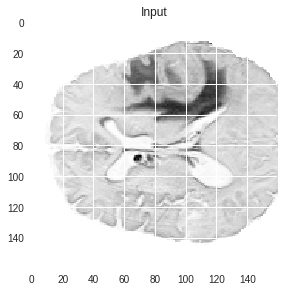

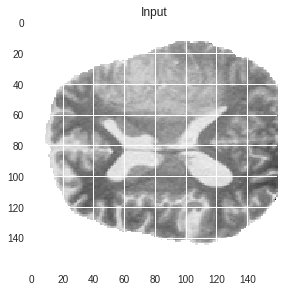

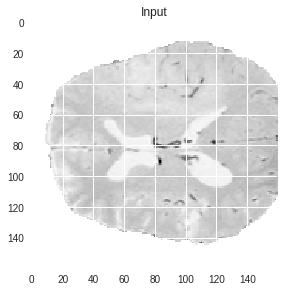

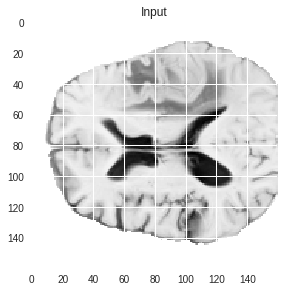

In [60]:
num = int(prediction.shape[4]/2)
for n in range(4):
    i = int(r.random() * prediction.shape[1])
    plt.figure(figsize=(15,10))

    plt.subplot(131)
    plt.title('Input')
    plt.imshow(X[1, n, :, :, num])

#     plt.subplot(132)
#     plt.title('Ground Truth')
#     plt.imshow(y[n, 1, :, :, num])

#     plt.subplot(133)
#     plt.title('Prediction')
#     plt.imshow(prediction[n, 1, :, :, num])

    plt.show()